# In Depth: Kernel Density Estimation
Kernel density estimation (KDE) is in some senses an algorithm that takes the mixture-of-Gaussians idea to its logical extreme: it uses a mixture consisting of one Gaussian component per point, resulting in an essentially nonparametric estimator of density.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

## Motivating KDE: Histograms
A density estimator is an algorithm that seeks to model the probability distribution that generated a dataset. For one-dimensional data, a simple density estimator is the histogram. A histogram divides the data into discrete bins, counts the number of points that fall in each bin, and then visualizes the results in an intuitive manner. Let's create some data:

In [2]:
def make_data(N, f=0.3, rseed=1):
    rand = np.random.RandomState(rseed)
    x = rand.randn(N)
    x[int(f * N):] += 5
    return x

x = make_data(1000)

By specifying the `normed` parameter of the histogram, we end up with a normalized histogram where the height of the bins does not reflect counts, but instead reflects probability density.

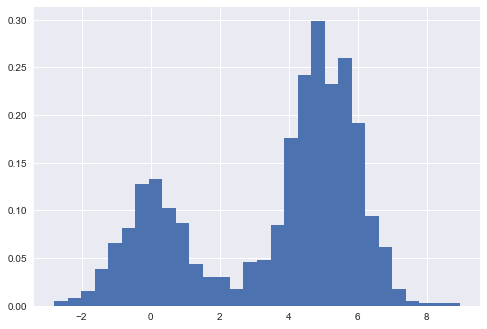

In [3]:
hist = plt.hist(x, bins=30, normed=True)

This normalization simply changes the scale on the y-axis, leaving the relative heights essentially the same as in a histogram built from counts. This normalization is chosen so that the total area under the hist is equal to 1.

In [4]:
density, bins, patches = hist
widths = bins[1:] - bins[:-1]
(density * widths).sum()

1.0

An issue with a histogram as a density estimator is that the choice of bin size and location can lead to representations that have qualitatively different features. If we look at a version of this data with only 20 points, the choice of how to draw the bins can lead to an entirely different interpretation of the data.

In [5]:
x = make_data(20)
bins = np.linspace(-5, 10, 10)

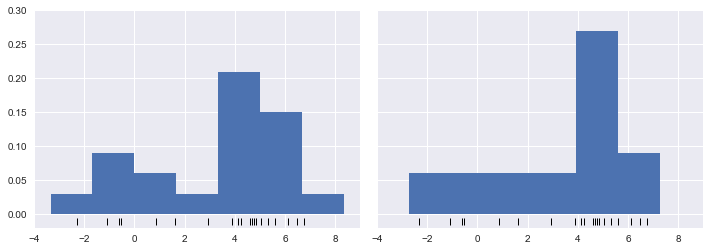

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4),
                       sharex=True, sharey=True,
                       subplot_kw={'xlim':(-4,9),
                                   'ylim':(-0.02, 0.3)})
fig.subplots_adjust(wspace=0.05)
for i, offset in enumerate([0.0, 0.6]):
    ax[i].hist(x, bins=bins + offset, normed=True)
    ax[i].plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)

On the left, the histogram makes clear that this is a bimodal distribution. On the right, we see a unimodal distribution with a long tail. You would probably not guess these two histograms were built from the same data. How might we improve this?

We can think of a histogram as a stack of blocks, where we stack one block within each bin on top of each point in the dataset.

(-0.2, 8)

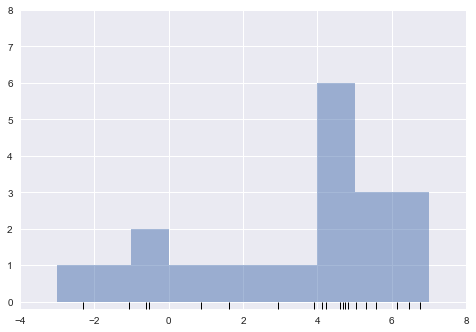

In [7]:
fix, ax = plt.subplots()
bins = np.arange(-3, 8)
ax.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)
for count, edge in zip(*np.histogram(x, bins)):
    for i in range(count):
        ax.add_patch(plt.Rectangle((edge, i), 1, 1, alpha=0.5))
ax.set_xlim(-4, 8)
ax.set_ylim(-0.2, 8)

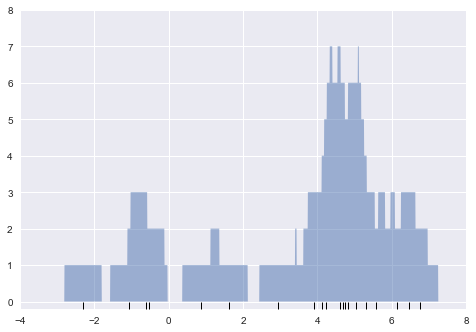

In [8]:
# stack blocks aligned with points instead of bins
x_d = np.linspace(-4,8, 2000)
density = sum((abs(xi - x_d) < 0.5) for xi in x)

plt.fill_between(x_d, density, alpha=0.5)
plt.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)

plt.axis([-4, 8, -0.2, 8]);

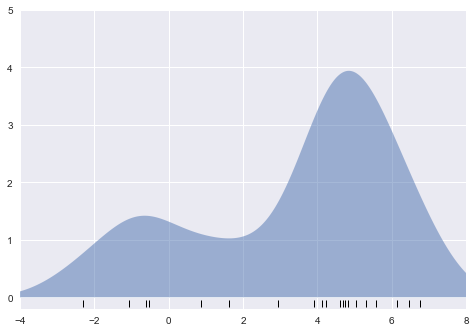

In [9]:
# use standard normal curve instead of blocks to smooth out plot
from scipy.stats import norm
x_d = np.linspace(-4,8, 1000)
density = sum(norm(xi).pdf(x_d) for xi in x)

plt.fill_between(x_d, density, alpha=0.5)
plt.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)

plt.axis([-4, 8, -0.2, 5]);

## Kernel Density Estimation in Practice
The free parameters of kernel density estimation are the *kernel*, which specifies the shape of the distribution place at each point, and the *kernel bandwidth*, which controls the size of the kernel at each point. Scikit-Learn KDE implementation supports one of six kernels and one of a couple dozen distance metrics. 

KDE is fairly computationally intensive, so Scikit-Learn estimator uses a tree-based algorithm under the hood and can trade off computation time for accuracy using the `atol` (absolute tolerance) and `rtol` (relative tolerance) parameters. We will use cross validation to determine the kernel bandwidth.

(-0.02, 0.22)

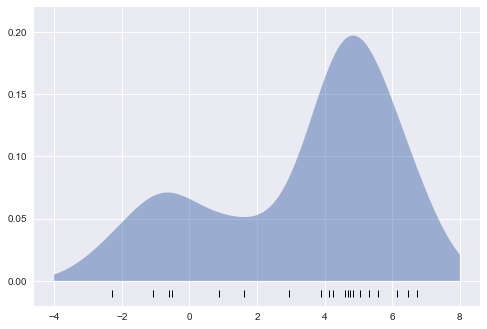

In [10]:
from sklearn.neighbors import KernelDensity

# instantiate and fit the KDE model
kde = KernelDensity(bandwidth=1.0, kernel='gaussian')
kde.fit(x[:, None])

# score_samples returns the log of the probability density
logprob = kde.score_samples(x_d[:, None])

plt.fill_between(x_d, np.exp(logprob), alpha=0.5)
plt.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
plt.ylim(-0.02, 0.22)

#### Selecting the bandwidth via cross-validation
The choice of bandwidth within KDE is extremely important to finding a suitable density estimate, and is the knob that controls the bias-variance trade-off in the estimate of density. Too narrow a bandwidth results in a high-variance estimate. Too wide a bandwidth leads to a high-bias estimate (underfitting) where the structure of the data is washed out by the wide kernel.

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.cross_validation import LeaveOneOut

In [15]:
# use LeaveOneOut because of small dataset
bandwidths = 10 ** np.linspace(-1, 1, 100)
grid = GridSearchCV(KernelDensity(kernel='gaussian'), {'bandwidth':bandwidths},
                    cv=LeaveOneOut(len(x)))
grid.fit(x[:, None]);

In [16]:
# find bandwidth that maximizes score
grid.best_params_

{'bandwidth': 1.1233240329780276}

The optimal bandwidth is 1.123.

## Example: KDE on a Sphere
One of the most common use of KDE is in graphically representing distributions of points. Here we will use some geographic data summarizing recorded observations of two South American mammals, sloth and rat.

In [17]:
from sklearn.datasets import fetch_species_distributions
data = fetch_species_distributions()

# get matrices/arrays of species IDs and locations
latlon = np.vstack([data.train['dd lat'],
                    data.train['dd long']]).T
species = np.array([d.decode('ascii').startswith('micro')
                    for d in data.train['species']], dtype='int')

In [18]:
from mpl_toolkits.basemap import Basemap
from sklearn.datasets.species_distributions import construct_grids

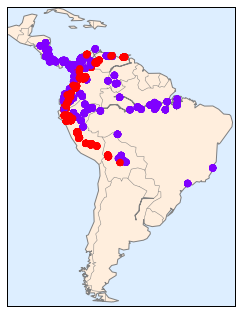

In [20]:
xgrid, ygrid = construct_grids(data)

# plot coastlines with Basemap
m = Basemap(projection='cyl', resolution='c',
            llcrnrlat=ygrid.min(), urcrnrlat=ygrid.max(),
            llcrnrlon=xgrid.min(), urcrnrlon=xgrid.max())
m.drawmapboundary(fill_color='#DDEEFF')
m.fillcontinents(color='#FFEEDD')
m.drawcoastlines(color='gray', zorder=2)
m.drawcountries(color='gray', zorder=2)

# plot locations
m.scatter(latlon[:, 1], latlon[:, 0], zorder=3,
          c=species, cmap='rainbow', latlon=True);

Unfortunately this doesn't give a very good idea of the density of the species, because points in the species range may overlap one another. There are actually over 1600 points on the plot above!

Let's use KDE to show this distribution in a more interpretable way.

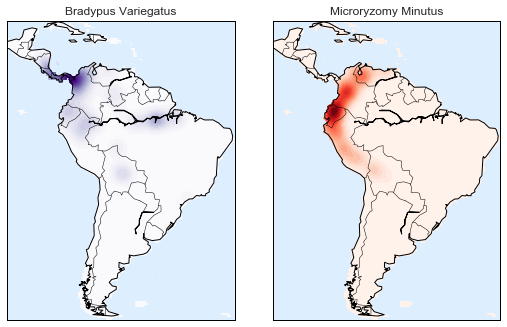

In [21]:
# Set up the data grid for the contour plot
X, Y = np.meshgrid(xgrid[::5], ygrid[::5][::-1])
land_reference = data.coverages[6][::5, ::5]
land_mask = (land_reference > -9999).ravel()
xy = np.vstack([Y.ravel(), X.ravel()]).T
xy = np.radians(xy[land_mask])

# create two side-by-side plots
fig, ax = plt.subplots(1, 2)
fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05)
species_names = ['Bradypus Variegatus', 'Microryzomy Minutus']
cmaps = ['Purples', 'Reds']

for i, axi in enumerate(ax):
    axi.set_title(species_names[i])
    
    # plot coastlines with Basemap
    m = Basemap(projection='cyl', llcrnrlat=Y.min(),
                urcrnrlat=Y.max(), llcrnrlon=X.min(),
                urcrnrlon=X.max(), resolution='c', ax=axi)
    m.drawmapboundary(fill_color='#DDEEFF')
    m.drawcoastlines()
    m.drawcountries()
    
    # construct a spherical kernel density estimate of the distribution
    # use haversine because coordinate system is spherical surface
    kde = KernelDensity(bandwidth=0.03, metric='haversine')
    kde.fit(np.radians(latlon[species == i]))
    
    # evaluate only on the land: -9999 indicates ocean
    Z = np.full(land_mask.shape[0], -9999.0)
    Z[land_mask] = np.exp(kde.score_samples(xy))
    Z = Z.reshape(X.shape)
    
    # plot contours of the density
    levels = np.linspace(0, Z.max(), 25)
    axi.contourf(X, Y, Z, levels=levels, cmap=cmaps[i])

## Example: Not-So-Naive Bayes
This example looks at Bayesian generative classification with KDE. For naive Bayes, the generative model is a simple axis-aligned Gaussian. With a density estimation algorithm like KDE, we can remove the "naive" element and perform the same classification with a more sophisticated generative model for each class. The general approach for generative classification is this:

    1. Split the training data by label
    2. For each set, fit a KDE to obtain a generative model of the data. This allows you for any observation x and label y to compute a likelihood P(x | y).
    3. From the number of examples of each class in the training set, compute the class prior, P(y).
    4. For an unknown point x, the posterior probability for each class is P(y | x) = P(x | y)P(y). The class that maximizes this posterior is the label assigned to the point.

In [57]:
from sklearn.base import BaseEstimator, ClassifierMixin


class KDEClassifier(BaseEstimator, ClassifierMixin):
    """Bayesian generative classification based on KDE
    
    Parameters
    ----------
    bandwidth : float
        the kernel bandwidth within each class
    kernel : str
        the kernel name, passed to KernelDensity
    """
    def __init__(self, bandwidth=1.0, kernel='gaussian'):
        self.bandwidth = bandwidth
        self.kernel = kernel
        
    def fit(self, X, y):
        self.classes_ = np.sort(np.unique(y))
        training_sets = [X[y == yi] for yi in self.classes_]
        self.models_ = [KernelDensity(bandwidth=self.bandwidth, kernel=self.kernel).fit(Xi) for Xi in training_sets]
        self.logpriors_ = [np.log(Xi.shape[0] / X.shape[0]) for Xi in training_sets]
        return self
        
    def predict_proba(self, X):
        logprobs = np.array([model.score_samples(X) for model in self.models_]).T
        result = np.exp(logprobs + self.logpriors_)
        return result / result.sum(1, keepdims=True)
        
    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), 1)]

#### Using out custom estimator
Classification of handwritten digits.

In [58]:
from sklearn.datasets import load_digits
from sklearn.model_selection import GridSearchCV

In [59]:
digits = load_digits()

In [60]:
bandwidths = 10 ** np.linspace(0, 2, 100)

In [61]:
grid = GridSearchCV(KernelDensity(), {'bandwidth': bandwidths})

In [62]:
grid.fit(digits.data, digits.target)

GridSearchCV(cv=None, error_score='raise',
       estimator=KernelDensity(algorithm='auto', atol=0, bandwidth=1.0, breadth_first=True,
       kernel='gaussian', leaf_size=40, metric='euclidean',
       metric_params=None, rtol=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'bandwidth': array([   1.     ,    1.04762, ...,   95.45485,  100.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [63]:
scores = [val.mean_validation_score for val in grid.grid_scores_]

/Volumes/RobStorage/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


{'bandwidth': 1.5922827933410924}
accuracy = -86782.4388019


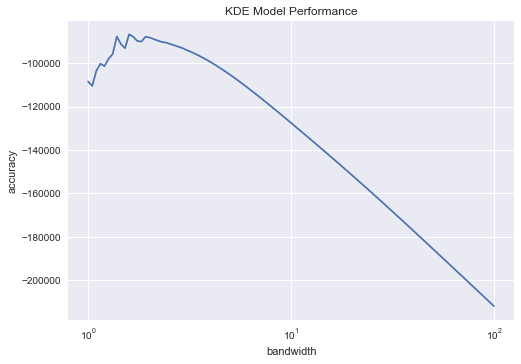

In [64]:
plt.semilogx(bandwidths, scores)
plt.xlabel('bandwidth')
plt.ylabel('accuracy')
plt.title('KDE Model Performance')

print grid.best_params_
print "accuracy =", grid.best_score_

We see that this not-so-naive Bayesian classifier reaches a cross-validation accuracy of just over 96% vs. 80% for the naive Bayesian classification:

In [66]:
from sklearn.naive_bayes import GaussianNB
from sklearn.cross_validation import cross_val_score
cross_val_score(GaussianNB(), digits.data, digits.target).mean()

0.81860038035501381

One benefit of such a generative classifier is interpretability of results: for each unknown sample, we not only get a probabilistic classification, but a full model of the distribution of points we are comparing it to!